In [1]:
# Python modules.
import datetime as dt
import os
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../data")


# Other modules.
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)
import numpy as np
import pandas as pd
from sklearn.metrics import (
    mean_squared_error,
)

# Library.
from src.utils import (
    make_a_sound,
    prepare_submission,
    submit_file,
    get_submission_scores,
)
from src.eda import (
    distplot,
    correlation_heatmap,
    compare_predictions_and_real_values,
    vizualize_feature_importance,
    vizualise_residual,
)
from src.preprocessing import (
    compute_statistical_df_focusing_on_output_and_specific_column,
    create_new_columns_based_on_categorical_columns,
    fill_df_navalues,
    scale_and_encoder_features,
    encode_categories_using_encoders_and_scalers,
    split_X_y_in_train_test_sets,
    create_polynomial_features,
    get_dummies,
    generate_polynomial_column_using_polynomial_feature_encoder,
)

In [2]:
# Environment
pd.set_option("display.max_columns", 140)

In [3]:
# Loading data
df_train = (
    pd.concat([
        pd.read_csv("data/train.csv"),
        pd.read_csv("data/training_extra.csv"),
    ])
)
df_test = pd.read_csv("data/test.csv")

### EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 365.7+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 193773 non-null  object 
 2   Material              194387 non-null  object 
 3   Size                  195619 non-null  object 
 4   Compartments          200000 non-null  float64
 5   Laptop Compartment    195038 non-null  object 
 6   Waterproof            195189 non-null  object 
 7   Style                 194847 non-null  object 
 8   Color                 193215 non-null  object 
 9   Weight Capacity (kg)  199923 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 15.3+ MB


<Figure size 1900x1000 with 0 Axes>

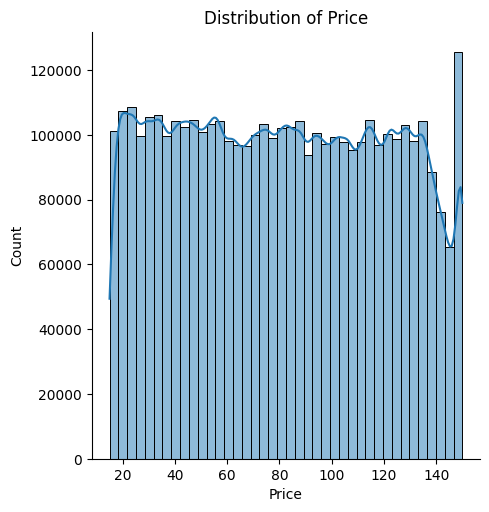

In [6]:
distplot(df=df_train, variable_name="Price")


<Figure size 1900x1000 with 0 Axes>

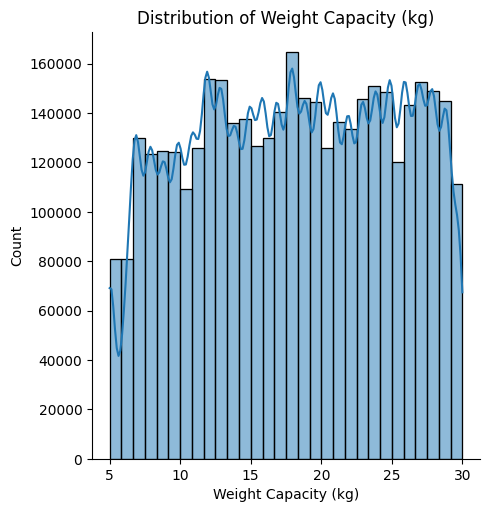

In [7]:
distplot(df=df_train, variable_name="Weight Capacity (kg)", bins=30)

## Setting reference

In [8]:
# Reference price - Settign ref score.
ref_price = df_train.Price.mean()
print(f"Mean price: {ref_price:.3f}.")
ref_score = np.sqrt(
    mean_squared_error(
        y_true=df_train.loc[:, "Price"],
        y_pred=np.ones(len(df_train)) * ref_price,
        )
    )
print(f"ref RMSE: {ref_score:.4f}")

Mean price: 81.362.
ref RMSE: 38.9387


## Preprocessing

In [9]:
categorical_column_names = list(df_train.columns[1:-2])
print(f"There are {len(categorical_column_names)} categorical columns.")
numerical_column_names = ["Weight Capacity (kg)"]
print(f"There are {len(numerical_column_names)} numerical columns.")

There are 8 categorical columns.
There are 1 numerical columns.


In [10]:
# Merging both before preprocessing the data.
df_tot = pd.concat([df_train, df_test])

In [11]:
# Preprocessing
# Optimize inputs cache memory.
## Train
df_tot["id"] = df_tot["id"].astype("int32")
df_tot["Weight Capacity (kg)"] = df_tot["Weight Capacity (kg)"].astype("float32")
df_tot["Price"] = df_tot["Price"].astype("float32")
df_tot_filled = fill_df_navalues(df=df_tot)
for column_name in categorical_column_names:
    df_tot_filled[column_name] = df_tot_filled[column_name].astype("category")
df_tot_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4194318 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int32   
 1   Brand                 category
 2   Material              category
 3   Size                  category
 4   Compartments          category
 5   Laptop Compartment    category
 6   Waterproof            category
 7   Style                 category
 8   Color                 category
 9   Weight Capacity (kg)  float32 
 10  Price                 float32 
dtypes: category(8), float32(2), int32(1)
memory usage: 112.0 MB


## Creating new features

In [13]:
def find_weight_group(x):
    if x <= 7:
        return "Low Low"
    elif (x > 7) & (x <= 15):
        return "Low"
    elif (x > 15) & (x <= 22):
        return "Low Medium"
    elif (x > 22) & (x <= 30):
        return "Medium"
    elif (x > 30) & (x <= 37):
        return "Medium"
    else:
        return "High"


def find_compartment_group(x):
    if x <= 3:
        return "Low"
    elif (x > 3) & (x <= 5):
        return "Medium"
    elif (x > 5) & (x <= 7):
        return "Medium Plus"
    elif x > 7.0:
        return "High"


def find_style(x):
    if x in ["Under Armour", "Nike"]:
        return "Street Wear"
    elif x == "Jansport":
        return "Casual"
    elif x in ["Adidas", "Puma"]:
        return "Fancy Street Wear"


def find_material_price(x):
    if x in ["Leather"]:
        return "Expensive"
    elif x in ["Canvas", "Nylon"]:
        return "Medium"
    elif x in ["Polyester"]:
        return "Cheap"


def create_new_features(input_df: pd.DataFrame) -> pd.DataFrame:
    """Create variables using deduction and previous variables.
    Creating categories basically.

    :param input_df:
    :return pd.DataFrame:
    """
    output_df = input_df.copy()
    output_df["Weight Group"] = output_df["Weight Capacity (kg)"].apply(
        lambda x: find_weight_group(x)
    ).astype("category")
    output_df["Compartement Group"] = output_df["Compartments"].apply(
        lambda x: find_compartment_group(x)
    ).astype("category")
    output_df["Brand Style"] = output_df["Brand"].apply(lambda x: find_style(x)).astype("category")
    output_df["Material Category"] = output_df["Material"].apply(lambda x: find_material_price(x)).astype("category")
    output_df["Weight Capacity (kg) exp"] = np.expm1(output_df["Weight Capacity (kg)"]).astype("float64")
    output_df["Weight Capacity (kg) log1"] = np.log1p(output_df["Weight Capacity (kg)"])
    output_df["wg_compartment"] = output_df[["Weight Group", "Compartement Group"]].sum(axis=1).astype("category")
    output_df["wg_brand"] = output_df[["Weight Group", "Brand Style"]].sum(axis=1).astype("category")
    output_df["wg_material"] = output_df[["Weight Group", "Material Category"]].sum(axis=1).astype("category")
    output_df["wg_style"] = output_df[["Weight Group", "Style"]].sum(axis=1).astype("category")
    output_df["wg_color"] = output_df[["Weight Group", "Color"]].sum(axis=1).astype("category")
    return output_df


df_tot_with_new_vars = create_new_features(input_df=df_tot_filled)
df_tot_with_new_vars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4194318 entries, 0 to 199999
Data columns (total 22 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   id                         int32   
 1   Brand                      category
 2   Material                   category
 3   Size                       category
 4   Compartments               category
 5   Laptop Compartment         category
 6   Waterproof                 category
 7   Style                      category
 8   Color                      category
 9   Weight Capacity (kg)       float32 
 10  Price                      float32 
 11  Weight Group               category
 12  Compartement Group         category
 13  Brand Style                category
 14  Material Category          category
 15  Weight Capacity (kg) exp   float64 
 16  Weight Capacity (kg) log1  float32 
 17  wg_compartment             category
 18  wg_brand                   category
 19  wg_material                

In [14]:
df_tot_with_new_vars

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,Weight Group,Compartement Group,Brand Style,Material Category,Weight Capacity (kg) exp,Weight Capacity (kg) log1,wg_compartment,wg_brand,wg_material,wg_style,wg_color
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.158752,Low,Medium Plus,Casual,Expensive,1.103833e+05,2.534627,LowMedium Plus,LowCasual,LowExpensive,LowTote,LowBlack
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.880562,Medium,High,Casual,Medium,5.755183e+11,3.335006,MediumHigh,MediumCasual,MediumMedium,MediumMessenger,MediumGreen
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643761,39.173199,Low Medium,Low,Street Wear,Expensive,1.691583e+07,2.870382,Low MediumLow,Low MediumStreet Wear,Low MediumExpensive,Low MediumMessenger,Low MediumRed
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937221,80.607933,Low,High,Street Wear,Medium,4.154918e+05,2.634563,LowHigh,LowStreet Wear,LowMedium,LowMessenger,LowGreen
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.023117,Low Medium,Low,Fancy Street Wear,Medium,5.110220e+07,2.931159,Low MediumLow,Low MediumFancy Street Wear,Low MediumMedium,Low MediumMessenger,Low MediumGreen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499995,Adidas,Canvas,Large,2.0,Yes,No,Messenger,Red,7.383498,80.984955,Low,Low,Fancy Street Wear,Medium,1.608209e+03,2.126265,LowLow,LowFancy Street Wear,LowMedium,LowMessenger,LowRed
199996,499996,Nike,Polyester,Small,9.0,No,Yes,Messenger,Pink,6.058394,80.984955,Low Low,High,Street Wear,Cheap,4.266882e+02,1.954218,Low LowHigh,Low LowStreet Wear,Low LowCheap,Low LowMessenger,Low LowPink
199997,499997,Jansport,Nylon,Small,9.0,No,Yes,Tote,Green,26.890163,80.984955,Medium,High,Casual,Medium,4.767049e+11,3.328274,MediumHigh,MediumCasual,MediumMedium,MediumTote,MediumGreen
199998,499998,Puma,Nylon,Large,10.0,Yes,No,Tote,Gray,25.769154,80.984955,Medium,High,Fancy Street Wear,Medium,1.553822e+11,3.287250,MediumHigh,MediumFancy Street Wear,MediumMedium,MediumTote,MediumGray


In [15]:
# Scaling
df_tot_with_new_vars_scaled, scalers_and_encoders = scale_and_encoder_features(
    df=df_tot_with_new_vars,
    skip_column_names=["Weight Capacity (kg)", "Weight Capacity (kg) log1", "Weight Capacity (kg) exp", "Price"],
)
df_tot_with_new_vars_scaled.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4194318 entries, 0 to 199999
Data columns (total 22 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   id                         int32   
 1   Brand                      category
 2   Material                   category
 3   Size                       category
 4   Compartments               category
 5   Laptop Compartment         category
 6   Waterproof                 category
 7   Style                      category
 8   Color                      category
 9   Weight Capacity (kg)       float32 
 10  Price                      float32 
 11  Weight Group               category
 12  Compartement Group         category
 13  Brand Style                category
 14  Material Category          category
 15  Weight Capacity (kg) exp   float64 
 16  Weight Capacity (kg) log1  float32 
 17  wg_compartment             category
 18  wg_brand                   category
 19  wg_material                

In [16]:
df_tot_dummy = get_dummies(df=df_tot_with_new_vars_scaled)
df_tot_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4194318 entries, 0 to 199999
Columns: 130 entries, id to wg_color_23
dtypes: float32(128), float64(1), int32(1)
memory usage: 2.1 GB


In [17]:
# categorical_column_names = categorical_column_names + [
#     "Weight Group",
#     "Compartement Group",
#     "Brand Style",
#     "Material Category",
#     "wg_compartment",
#     "wg_brand",
#     "wg_material",
#     "wg_style",
#     "wg_color",
# ]
categorical_column_names = [
    column_name
    for column_name in df_tot_dummy.columns
    if column_name.startswith("Brand")
    or column_name.startswith("Material")
    or column_name.startswith("Size")
    or column_name.startswith("Color")
    or column_name.startswith("Style")
    or column_name.startswith("Laptop Compartment")
    or column_name.startswith("Waterproof")
    or column_name.startswith("Compartments")
    or column_name.startswith("Weight Group")
    or column_name.startswith("Compartement Group")
    or column_name.startswith("Material Category")
    or column_name.startswith("wg")
]
set(categorical_column_names).symmetric_difference(set(df_tot_dummy.columns.tolist()))

{'Price',
 'Weight Capacity (kg)',
 'Weight Capacity (kg) exp',
 'Weight Capacity (kg) log1',
 'id'}

In [18]:
df_tot_with_new_vars2_scaled = create_new_columns_based_on_categorical_columns(
    df=df_tot_dummy,
    categorical_columns=categorical_column_names,
    output_col_name="Weight Capacity (kg)",
)
df_tot_with_new_vars2_scaled.info()

/Users/Baptiste/Documents/swag2-backpack-predict/notebooks/../src/preprocessing.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_cn] = (
/Users/Baptiste/Documents/swag2-backpack-predict/notebooks/../src/preprocessing.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_cn] = (
/Users/Baptiste/Documents/swag2-backpack-predict/notebooks/../src/preprocessing.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

<class 'pandas.core.frame.DataFrame'>
Index: 4194318 entries, 0 to 199999
Columns: 255 entries, id to wg_color_23_wc
dtypes: float32(253), float64(1), int32(1)
memory usage: 4.0 GB


/Users/Baptiste/Documents/swag2-backpack-predict/notebooks/../src/preprocessing.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_cn] = (
/Users/Baptiste/Documents/swag2-backpack-predict/notebooks/../src/preprocessing.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_cn] = (
/Users/Baptiste/Documents/swag2-backpack-predict/notebooks/../src/preprocessing.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

### Correlation matrix.

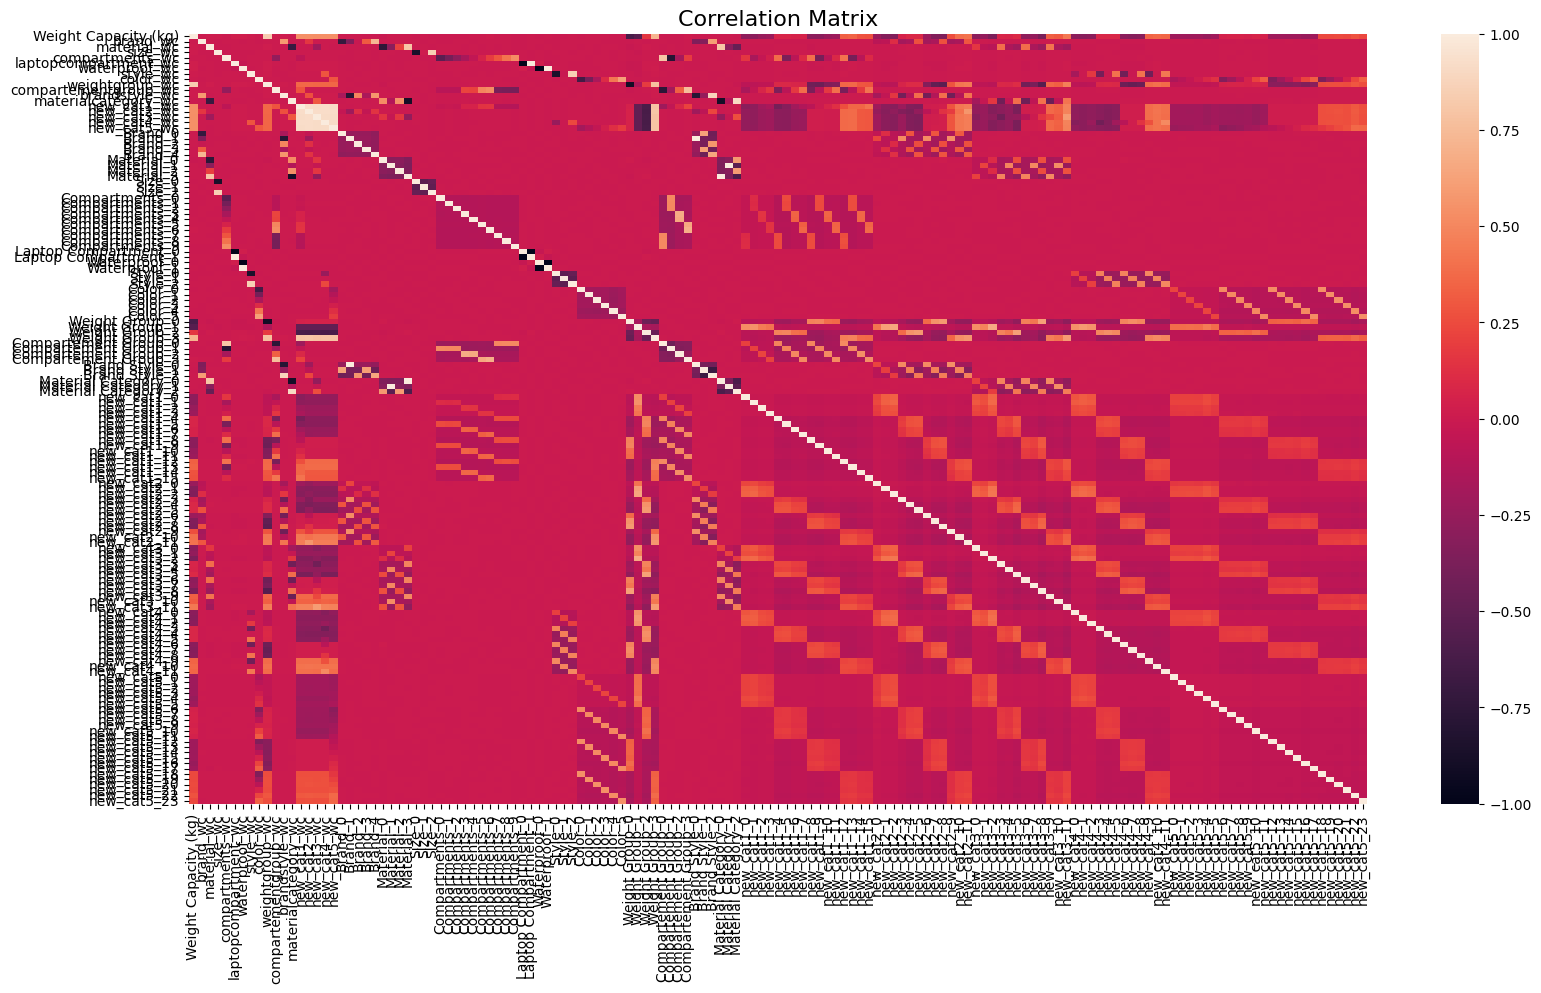

In [87]:
corr = (
    df_tot_dummy
    .select_dtypes(include=["float32", "float64", "int32", "int64"])
    .drop(columns=["id", "index"], errors='ignore')
    .corr()
)
correlation_heatmap(df_correlation=corr)

In [19]:
# Retrieving df_train & df_test
df_train_dummy = df_tot_dummy[:len(df_train)]
df_test_dummy = df_tot_dummy[len(df_train):].drop(columns=["Price"])

In [20]:
df_train_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3994318 entries, 0 to 3694317
Columns: 130 entries, id to wg_color_23
dtypes: float32(128), float64(1), int32(1)
memory usage: 2.0 GB


In [21]:
df_test_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 199999
Columns: 129 entries, id to wg_color_23
dtypes: float32(127), float64(1), int32(1)
memory usage: 100.7 MB


In [22]:
column_names = df_train_dummy.drop(columns=["Price", "index", "id"], errors="ignore").columns
X = df_train_dummy.loc[:, column_names]
y = df_train_dummy.loc[:, ["Price"]]
X_train, X_test, y_train, y_test = split_X_y_in_train_test_sets(X=X, y=y, test_size=0.1)
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (3594886, 128)
Test shape: (399432, 128)


In [23]:
from sklearn.linear_model import (
    Ridge,
    LinearRegression,
    Lasso,
)
from sklearn.ensemble import (
    RandomForestRegressor,
)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from src.model import (
    get_linear_regression_model,
    get_ridge_model,
    get_lasso_model,
    get_random_forest_model,
    get_xgboost_model,
    get_catboost_model,
    get_lgbm_model,
    run_grid_search,
)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import neptune


CV = 2
run = neptune.init_run(
    project=os.environ["NEPTUNE_PROJECT"],
    api_token=os.environ["NEPTUNE_KEY"],
)
best_model, parameters = get_xgboost_model()
run["algorithm"] = type(best_model).__name__
start_time = dt.datetime.now()
best_model, cv_results = run_grid_search(
    model=best_model,
    parameters=parameters,
    X_train=X_train,
    y_train=y_train.values.reshape(-1),
    number_of_split=CV,  # cv value, not too high please
)
run["model/parameters"] = str(best_model.get_params())
run["model/train_size"] = str(X_train.shape)
run["model/cross_validation"] = CV
total_time_in_minutes = round((dt.datetime.now() - start_time).seconds / 60)
run["model/run_time_minutes"] = str(total_time_in_minutes)
print(f"L'entrainement a pris {str(round(total_time_in_minutes))} minutes.")
make_a_sound(message="Entrainement du modèle terminé.")
y_test_pred = best_model.predict(X_test)
score = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_pred))
run["model/score"] = str(score)
print(f"Score: {score}.")
final_model = XGBRegressor(**best_model.get_params())
final_model.fit(X_train, y_train)
y_test_final_predict = final_model.predict(X_test)
final_score = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_final_predict))
print(f"Final score: {final_score}.")
run["model/final_score"] = str(final_score)
print("Selected params are:")
if isinstance(best_model, XGBRegressor) or isinstance(best_model, LGBMRegressor):
    print(f"LR: {best_model.get_params().get('learning_rate')}.")
    print(f"Max depth: {best_model.get_params().get('max_depth')}.")
    print(f"N estimators: {best_model.get_params().get('n_estimators')}.")
elif isinstance(best_model, CatBoostRegressor):
    print(f"depth: {best_model.get_params().get('depth')}.")
    print(f"iterations: {best_model.get_params().get('iterations')}.")
    print(f"l2_leaf_reg: {best_model.get_params().get('l2_leaf_reg')}.")
    print(f"learning_rate: {best_model.get_params().get('learning_rate')}.")
elif isinstance(best_model, Ridge) or isinstance(best_model, Lasso):
    print(f"Alpha: {best_model.get_params().get('alpha')}.")
elif isinstance(best_model, LinearRegression):
    print(f"Intercept: {best_model.get_params().get('fit_intercept')}.")
elif isinstance(best_model, RandomForestRegressor):
    print(f"n_estimators: {best_model.get_params().get('n_estimators')}.")
    print(f"max_depth: {best_model.get_params().get('max_depth')}.")
elif isinstance(best_model, KNeighborsRegressor):
    print(f"n_neighbors: {best_model.get_params().get('n_neighbors')}.")
    print(f"weights: {best_model.get_params().get('weights')}.")
else:
    raise TypeError(f"{type(best_model)}")
print(f"Score: {score:.2f}")
ref_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=np.ones(len(y_test))*ref_price))
print(f"Ref score is {ref_rmse}.")
print(f"Improvement of {(ref_rmse - score) * 100:.2f}% comparing to reference one.")
run.stop()

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/picx/kaggle-swag-competition/e/KAG-71
Fitting 2 folds for each of 120 candidates, totalling 240 fits
[CV 1/2] END gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=50;, score=-38.912 total time=  14.1s
[CV 2/2] END gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=50;, score=-38.942 total time=  14.0s
[CV 1/2] END gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-38.907 total time=  24.5s
[CV 2/2] END gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-38.937 total time=  22.4s
[CV 1/2] END gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=150;, score=-38.903 total time=  27.2s
[CV 2/2] END gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=150;, score=-38.933 total time=  27.4s
[CV 1/2] END gamma=0.5, learning_rate=0.01, max_depth=3, n_estimators=200;, score=-38.901 total time=  33.5s
[CV 2/2] END gamma=0.5, learning_rate=0.01, max_depth=3, 

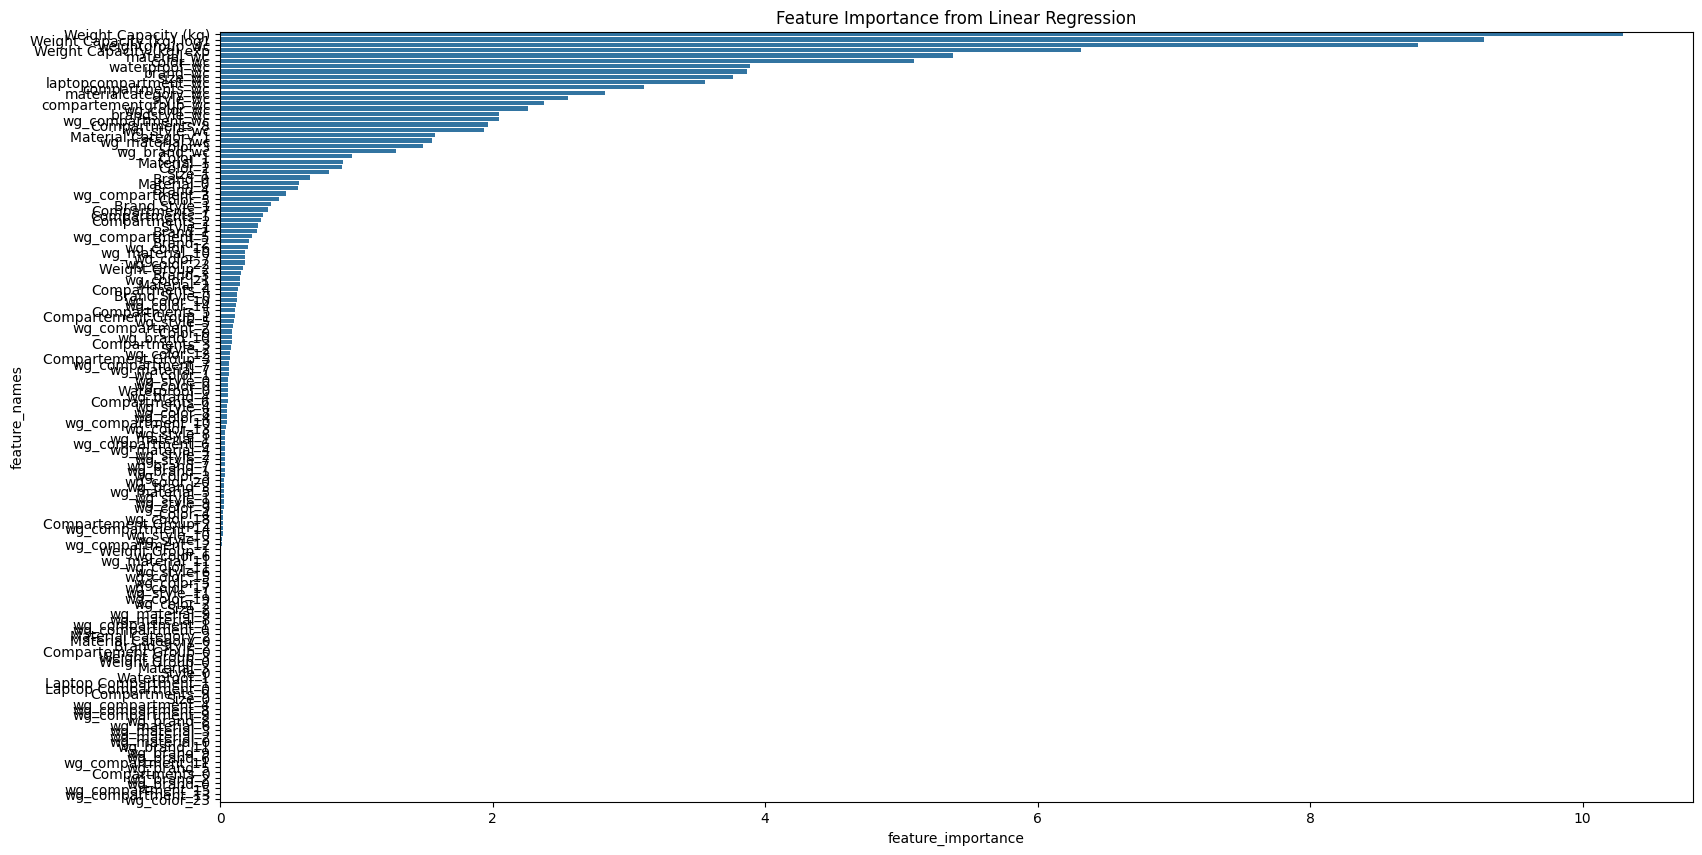

In [89]:
vizualize_feature_importance(
    model=final_model,
    feature_names=column_names,
)

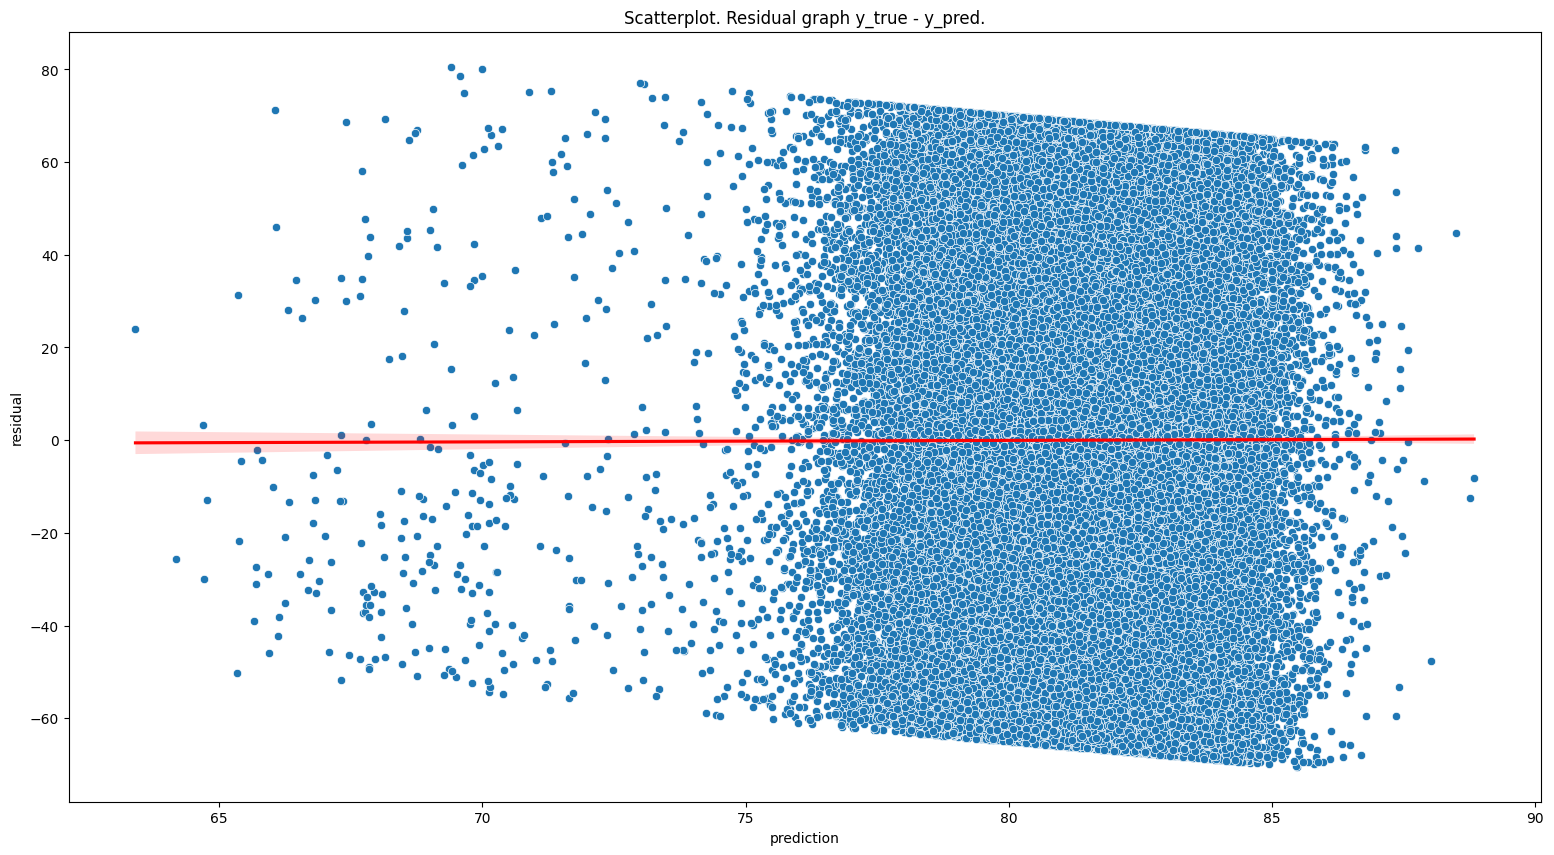

In [90]:
vizualise_residual(
    y_true=y_test["Price"].values,
    y_pred=final_model.predict(X_test[column_names]).reshape(-1),
    subset=100_000,
)

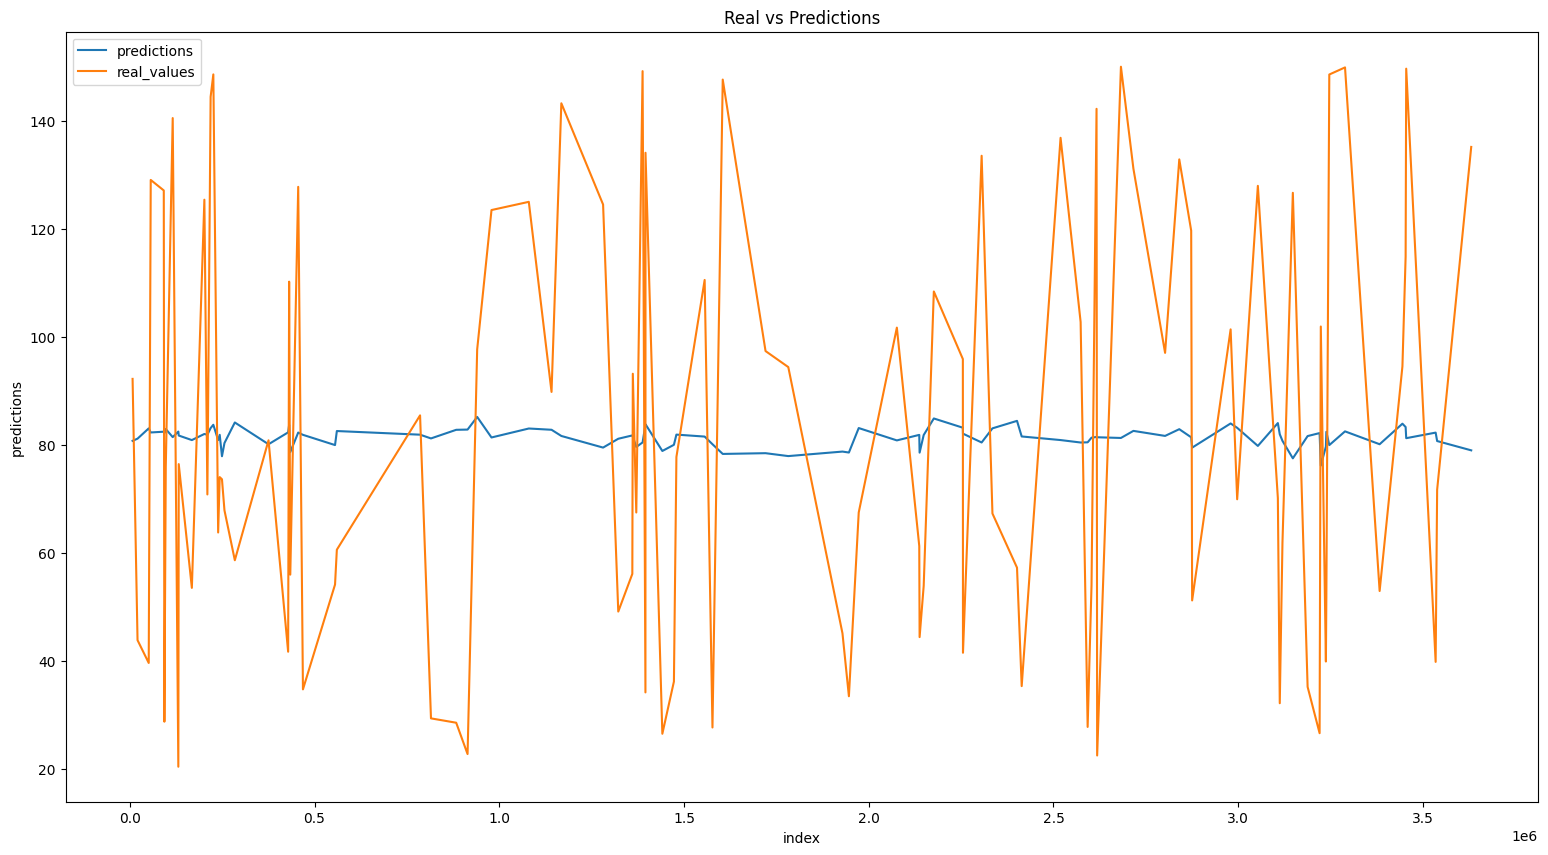

In [91]:
X_test["predictions"] = final_model.predict(X_test[column_names]).reshape(-1)
X_test["real_values"] = y_test.loc[:, ["Price"]]

compare_predictions_and_real_values(
    df=X_test.reset_index().iloc[:100]
)

In [107]:
df_test_dummy["Price_prediction"] = final_model.predict(df_test_dummy.loc[:, column_names])
df_test_dummy

,id,Weight Capacity (kg),Weight Capacity (kg) exp,Weight Capacity (kg) log1,brand_wc,material_wc,size_wc,compartments_wc,laptopcompartment_wc,waterproof_wc,...,wg_color_15,wg_color_16,wg_color_17,wg_color_18,wg_color_19,wg_color_20,wg_color_21,wg_color_22,wg_color_23,Price_prediction
0,300000,20.671146,9.492155e+08,3.075982,320.671143,120.671143,220.671143,120.671143,20.671146,20.671146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.297070
1,300001,13.564105,7.777059e+05,2.678560,213.564102,13.564105,113.564102,613.564087,13.564105,113.564102,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.356854
2,300002,11.809799,1.345635e+05,2.550210,11.809799,11.809799,11.809799,811.809814,11.809799,111.809799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.744458
3,300003,18.477036,1.057973e+08,2.969236,18.477036,218.477036,18.477036,18.477036,118.477036,18.477036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.224527
4,300004,9.907953,2.008851e+04,2.389492,409.907959,209.907959,9.907953,109.907951,109.907951,109.907951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.262826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,499995,7.383498,1.608209e+03,2.126265,7.383498,7.383498,7.383498,107.383499,107.383499,7.383498,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,80.839010
199996,499996,6.058394,4.266882e+02,1.954218,206.058395,306.058380,206.058395,806.058411,6.058394,106.058395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.364801
199997,499997,26.890163,4.767049e+11,3.328274,126.890167,226.890167,226.890167,826.890137,26.890163,126.890167,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,82.674154
199998,499998,25.769154,1.553822e+11,3.287250,325.769165,225.769150,25.769154,925.769165,125.769150,25.769154,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,82.016791


<Figure size 1900x1000 with 0 Axes>

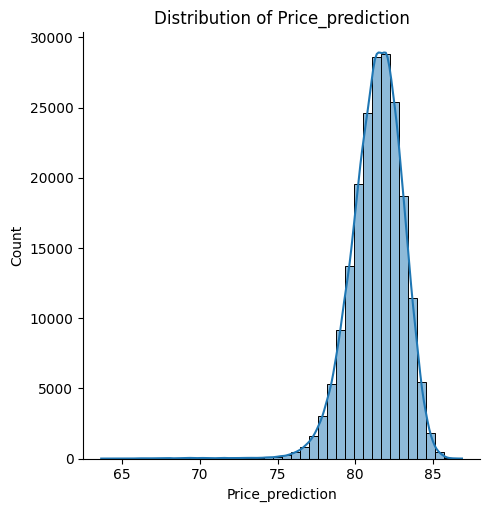

In [108]:
# distplot(df=df_test_filled_n, variable_name="log_Price_prediction")
distplot(df=df_test_dummy, variable_name="Price_prediction")

In [109]:
# df_test_dummy["Price_prediction"] = df_test_dummy["Price_prediction"].mean()
prepare_submission(df_predictions=df_test_dummy.rename(columns={"Price_prediction": "prediction"}))

Generating output: data/my_submission.csv.


In [111]:
submit_file(message="On tente des trucs v2.")
make_a_sound(message="Submission envoyé à Kaggle.")

Submitting data/my_submission.csv to competition:playground-series-s5e2


100%|██████████| 2.48M/2.48M [00:01<00:00, 1.95MB/s]


Message: Submission not allowed.
Time remaining: 7.4 hours.


In [112]:
get_submission_scores()

Retrieving scores from competition:playground-series-s5e2
43100898 - 39.12883 -  - 2025-02-25 16:27:20
43095969 - 39.13135 -  - 2025-02-25 11:50:15
43095781 - 39.12633 -  - 2025-02-25 11:35:47
43095657 - 39.12669 -  - 2025-02-25 11:25:53
43095333 - 39.10124 -  - 2025-02-25 11:00:05
43083685 - 39.10124 -  - 2025-02-24 21:38:31


[neptune] [warning] Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterTimeout
[neptune] [info   ] Communication with Neptune restored!
[neptune] [warning] Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterTimeout
[neptune] [warning] Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterTimeout
[neptune] [info   ] Communication with Neptune restored!
[neptune] [info   ] Communication with Neptune restored!
